In [34]:
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [35]:
data_dir = '../data/LIS-fingerspelling-dataset'
img_ex = cv2.imread(os.path.join(data_dir, 'a', 'a_ANTONIA_1_bottom.JPG'))
img_ex.shape

(415, 622, 3)

In [36]:
# Automatically creates a dataset form the referred directory. Load the full dataset, shuffle = True ensures randomness
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=123
)

# In order to iterare the element we must use the iterative method
data_iterator = dataset.as_numpy_iterator()
data_iterator

Found 7228 files belonging to 24 classes.


NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7ff45c739c90>)

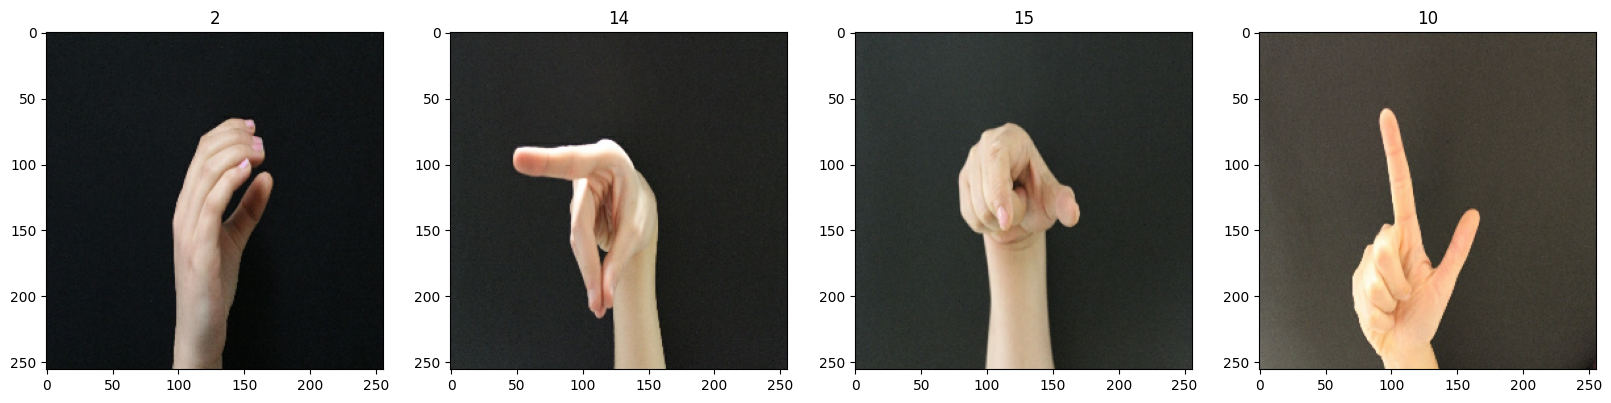

In [37]:
batch = data_iterator.next() # Grabbing a dataset batch

# Exploring a batch labels
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Data visualization

2025-05-22 13:48:23.725658: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


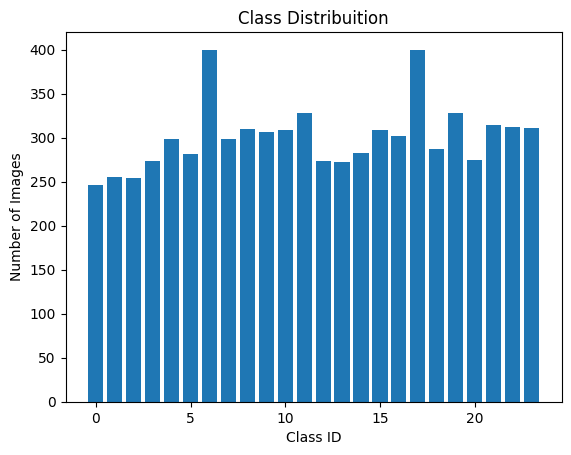

In [38]:
all_labels = []

for _, labels in dataset:
    all_labels.extend(labels.numpy())

label_counts = Counter(all_labels)

# Visualizza distribuzione
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Class Distribuition")
plt.show()

In [39]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def augment_and_save(data_dir, output_dir, img_size=(224, 224), noise_std=0.03):
    os.makedirs(output_dir, exist_ok=True)
    class_names = sorted(os.listdir(data_dir))
    
    for class_name in tqdm(class_names):
        class_dir = os.path.join(data_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)

        for filename in os.listdir(class_dir):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            path = os.path.join(class_dir, filename)
            img = cv2.imread(path)
            if img is None:
                continue

            # Resize and normalization
            img = cv2.resize(img, img_size)
            img = img[..., ::-1]  # BGR to RGB
            img = img.astype(np.float32) / 255.0

            # Saving original image
            original_filename = f"original_{filename}"
            original_path = os.path.join(output_class_dir, original_filename)
            cv2.imwrite(original_path, (img * 255).astype(np.uint8)[..., ::-1])

            # Flipped + noise
            flipped_img = cv2.flip(img, 1)
            noise = np.random.normal(0, noise_std, flipped_img.shape).astype(np.float32)
            noisy_flipped_img = np.clip(flipped_img + noise, 0.0, 1.0)

            # Saving flipped + noisy
            flipped_filename = f"flipped_noisy_{filename}"
            flipped_path = os.path.join(output_class_dir, flipped_filename)
            cv2.imwrite(flipped_path, (noisy_flipped_img * 255).astype(np.uint8)[..., ::-1])

data_dir = "../data/LIS-fingerspelling-dataset"
output_dir = "../data/processed/augmented"
augment_and_save(data_dir, output_dir, noise_std=0.03)

100%|██████████| 24/24 [00:48<00:00,  2.04s/it]


In [43]:
new_data_dir = '../data/processed/augmented'
new_dataset = tf.keras.utils.image_dataset_from_directory(
    new_data_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=123
)

# In order to iterare the element we must use the iterative method
datas = new_dataset.as_numpy_iterator()

Found 14456 files belonging to 24 classes.


In [46]:
batch = datas.next()

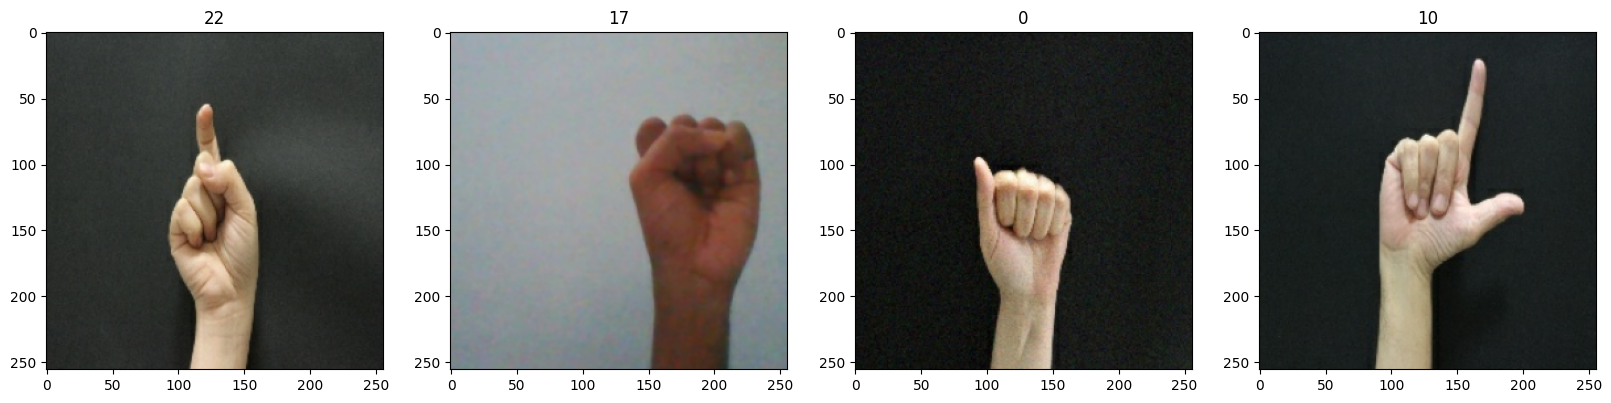

In [47]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
ax = ax.flatten()

for idx, img in enumerate(batch[0][:4]):
    if img.max() > 1.0:
        img_display = img.astype(np.uint8)
    else:
        img_display = img
    ax[idx].imshow(img_display)
    ax[idx].title.set_text(batch[1][idx])

plt.show()